# Assignment 2: Cell Tower Installation

## Instructions

This assignment is worth 10/100 points. 

You can do this assignment with someone else and it is about Local Search Algorithms, more specifically, Genetic Algorithms.

Answer to all the questions in english, argument, and justify your answers using the obtained results.

### Deadline
March 18th, 2023 at 23.59

### Some more Instructions
- You need to fill in your answers here and submit this jupyter notebook via NEO.
- It should run smoothly.
- Any compilation error will affect your total score. 


### Important before starting! 

- Only one of you should send the assignment, NOT BOTH!
- DO NOT copy the answers from internet nor from your classmates.
- If there are two or more groups that were discovered cheeting, then they will be penalized with 0/10.
- Use your brain and the material seen in class to program this assignment.
- You should be able to explain and modify your code according to your (or my) needs. 

## Problem Description
A local cellphone bolivian company wants to give cell phone signal to $n$ cities located in a remote place somewhere in Bolivia. 

They want to install cell towers that gives signal for $r$ Km around. The cost of installing a tower on land is not the same as the cost of installing it on a lake or on top of a hill. Thus, they want to minimize the amount of towers to be used and also the cost to be spent by installing each of them while giving signal to all cities (total coverage) such as in the picture below where we can see that all cities are covered. 

<div>
<img src="img/cities.png" width="500"/>
</div>


We will suppose that the signal radius of each tower is the same, independently if the tower is on top of a hill or on the land. 

### Some code to help you focus on the important part

We have already implemented part of the code to help you deal with some aspects of the problem such as the map representation, the cell tower coverage, part of the chromosome representation. 

In [2]:
import numpy as np
import random
from enum import Enum, auto
import copy
from matplotlib import colors, pyplot as plt
import matplotlib.patches as mpatches
from operator import attrgetter
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
class Chromosome:
    rows = 0
    cols = 0
    
    def __init__(self, gens):
        self.gens = gens
        self.probability = 0
        self.ind_fitness = self.__class__.fitness_function(self.get_coordinates(), self.count_towers())
    
    @classmethod
    def generate_random(cls, tower_pr):
        gens = [0] * cls.rows * cls.cols 
        for i in range(cls.rows * cls.cols): 
            if random.random() < tower_pr:
                gens[i] = 1 
        
        return Chromosome(gens)

    @classmethod 
    def set_fitness_function(cls, fun): 
        cls.fitness_function = fun

    def count_towers(self): 
        return sum(self.gens)  

    def get_coordinates(self): 
        r = self.__class__.rows 
        c = self.__class__.cols 
        matrix = [[None] * c for _ in range(r)] 
        
        for i in range(r): 
            for j in range(c): 
                matrix[i][j] = self.gens[i * r + j] 
        
        return np.array(matrix)
    


In [4]:
class SquareType(Enum): 
    water = auto() 
    land = auto() 
    hill = auto() 
    city = auto()

In [5]:
class Square: 
    def __init__(self, type, needs_coverage, tower_cost, is_covered = False): 
        self.tower_cost = tower_cost 
        self.needs_coverage = needs_coverage
        self.is_covered = is_covered 
        self.type = type 
        self.has_radar = False

In [6]:
class Landscape:
    def __init__(self, matrix): 
        self.matrix = matrix 
    
    def rows(self): 
        return len(self.matrix) 
    
    def cols(self): 
        return len(self.matrix[0])
    
    def add_towers(self, centroids, radius):
        r = radius
        
        for idx, x in np.ndenumerate(centroids):
            if centroids[idx[0],idx[1]] == 1:
                a, b = idx[0], idx[1]
                self.matrix[a][b].has_radar = True
                # draw the circle
                for y in range(self.rows()):
                    for x in range(self.cols()):
                        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
                        if abs((x-a)**2 + (y-b)**2) <= r**2:
                            self.matrix[y][x].is_covered = True
                            
    def uncovered_count(self):
        '''uncovered cities'''
        count = 0
        
        for y in range(self.rows()):
            for x in range(self.cols()):
                if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == False:
                    count+=1
                    
        return count

In [7]:
def generate_random_landscape(points, weights, rows, cols): 
    matrix = [[None] * cols for _ in range(rows)] 
    for i in range(rows): 
        for j in range(cols): 
            p = random.choices(points, weights.values()) 
            square = copy.deepcopy(p[0])
            square.tower_cost = round(square.tower_cost * (1 + random.uniform(0, .1))) 
            matrix[i][j] = square 
    
    return Landscape(matrix)

plt.rcParams['figure.figsize'] = [5,5]

def plot_landscape(landscape): 
    square_colors = { 
        SquareType.water: 1, 
        SquareType.land: 11, 
        SquareType.hill: 21, 
        SquareType.city: 31
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()):
        for j in range(landscape.cols()):
            m[i, j] = square_colors[landscape.matrix[i][j].type]
            
    col_list = ['blue', 'green', 'brown', 'black']
    labels = [s.name for s in square_colors.keys()] 
    cmap = colors.ListedColormap(col_list)
    bounds = [0, 10, 20, 30, 40] 
    norm = colors.BoundaryNorm(bounds, cmap.N) 
            
    plt.imshow(m, cmap = cmap, norm = norm) 
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1) 
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.3, 1), borderaxespad = 0.)
    plt.title('Landscape')
    plt.show()
    
def plot_coverage(landscape, title = "Coverage"):
    coverage_colors = { 
        'neutral': 1, 
        'is covered': 11, 
        'needs coverage': 21 
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    for i in range(landscape.rows()):
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].is_covered: 
                m[i, j] = coverage_colors['is covered'] 
            elif not landscape.matrix[i][j].needs_coverage: 
                m[i, j] = coverage_colors['neutral'] 
            elif landscape.matrix[i][j].needs_coverage:
                m[i, j] = coverage_colors['needs coverage']

    col_list = ['white', 'yellow', 'black'] 
    labels = list(coverage_colors.keys()) 
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20, 30] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1)
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.5, 1), borderaxespad = 0.)
    plt.title('Coverage')
    plt.show() 

def plot_costs(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            m[i, j] = landscape.matrix[i][j].tower_cost 
    plt.imshow(m, cmap = plt.cm.Reds)
    plt.colorbar()
    plt.title('Tower Construction Costs')
    plt.show()


def plot_towers_position(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].has_radar:
                m[j, i] = 11
            else:
                m[j, i] = 1

    col_list = ['white','black']
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.title('Towers Position')
    plt.show()

The cost of installing a cell tower on:
- Water (such as lakes): \$us 300K
- City: \$us 200K
- Hill: \$us 100K
- Land: \$us 30K

Each tower has a coverage of 7 Km around it.

In [8]:
# the purpose of this line is to reproduce your results
# random.seed(15)
# random.random()

# # map dimension:
# rows = 60
# cols = 60

# square_grid = { 
#     Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
#     Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
#     Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
#     Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
# }

# landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

# Chromosome.rows = rows
# Chromosome.cols = cols

# # fitness function undefined yet 
# def fitness_function(coords): 
    
#     return 0

# Chromosome.set_fitness_function(fitness_function) 
# cr = Chromosome.generate_random(.001)

# test_landscape = copy.deepcopy(landscape) 
# # coverage of 7km
# test_landscape.add_towers(cr.get_coordinates(), 7)

# towers = cr.count_towers() 
# uncovered = test_landscape.uncovered_count() 

# print(f'# Cell Towers: {towers}') 
# print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
# print(f'Uncovered Cities after cell towers: {uncovered}')

# plot_landscape(landscape) 
# plot_costs(landscape) 
# plot_coverage(landscape)

# print('Coverage after setting up the cell towers:')
# plot_coverage(test_landscape) 
# plot_towers_position(test_landscape)

## Tasks

1. Explain how you plan to use genetic algorithms to solve this problem and how your solution will work.
2. Implement a genetic algorithm to solve the problem. Plot the average fitness of the population for each generation.
3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 
4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 

# Answers

1. To solve this problem using genetic algorithms we can define a "fitness" function that contemplates the parameters that we are asked to optimize in the problem:

- the number of cities covered with towers in the landscape (maximize)
- the total cost of installing the towers (minimize)
- the total amount of towers used (minimize)

    we can use the operations seen in class: selection, crossover and mutation
    we can use the methods :  'tournament selection', 'single point crossover' or 'n-point crossover' , and bit shift mutation

    we need to evaluate the fitness of each chromosome using the landscape object and adding towers at positions indicated by their gens
    then we count the number of cities covered and uncovered with the count_cities ,method to calculate the fitness. also including the total cost of installation

    The higher the fitness, the stronger the chromosomes, and the closer they come to solving the problem.
    We can propose the following steps to solve the problem:

    initialization: we generate a first random generation

    selection: we choose the strongest of the population to be parents of the next generation

    crossover: we combine chromosomes to create new 'offsprings'

    mutation : we mutate random offsprings to give variety to the new generation

    we replace the less strong of the population with the new offsprings

    We finish the algorithm when we have offspring that meet our condition (when we find the strongest ones) or we reach a limit of generations that we give to the algorithm (example: 200 generations)


Implementation :

In [11]:
def fitness_function(coordinates, tr_count):
    # compute the total cost of installing towers
    total_cost = 0
    
    for y in range(landscape.rows()):
        for x in range(landscape.cols()):
            if coordinates[y][x] == 1:
                total_cost += landscape.matrix[y][x].tower_cost 

    uncovered_cities = landscape.uncovered_count()
    uncovered_cities = uncovered_cities*2000 #se esta diciendo que es bueno tener ciudades no cubiertas, mala idea. 
    
    tr_count *= 50

    fitness = (-uncovered_cities-total_cost - tr_count + 1000000)
    return fitness



In [13]:
# the purpose of this line is to reproduce your results
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

#landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

points = list(square_grid.keys())
weights = square_grid




#### 2. Genetic algortihm implementation:

In [17]:
def generate_population(n, tower_pr):

    Chromosome.set_fitness_function(fitness_function)
    population = []
    for _ in range(n):
        chromosome = Chromosome.generate_random(tower_pr)
        
        population.append(chromosome)

    return population

def assign_crossover_chance(population, population_fitness):
    for crhm in population:
        crhm.probability = crhm.ind_fitness / population_fitness

def crossover(parent1, parent2, crossover_point): #cambiar para M-point crossover, jugar con copias no con los cromosomas originales
        child_gens = parent1.gens[:int(len(parent1.gens)/crossover_point)] + parent2.gens[int(len(parent2.gens)/crossover_point):]
        return child_gens

def mutation(child): #jugar con copias no con los cromosomas originales
    idx = random.randint(0, len(child)-1)
    child[idx] = 1 - child[idx] #1-0 => 1, 1-1 => 0
    return child

def genetic_algorithm(tower_pr, pop_size, max_generations, mutation_rate, crossover_rate):
    
    generational_fitness = []
    better_generations = []
   
    population = generate_population(pop_size, tower_pr)

    for _ in range(max_generations): 
        population_fitness = 0
        population_weights=[]

        for crhm in population:
            population_fitness += crhm.ind_fitness
            population_weights.append(crhm.ind_fitness)
        
        assign_crossover_chance(population, population_fitness)

        new_population = [] 
        for _ in range(pop_size):

            # parent1= random.choices(population, weights = population_weights, k=1)
            # parent2= random.choices(population, weights = population_weights, k=1)

            parent1 = parent1[0]
            parent2 = parent2[0]
            
            # parent1 = random.choice(population)
            # parent2 = random.choice(population)

            copy_parent1 = copy.deepcopy(parent1)
            copy_parent2 = copy.deepcopy(parent2)
            
            if (random.random() <= crossover_rate):
                child_genetic = crossover(copy_parent1, copy_parent2, crossover_point=2)
                copy_child_gen=copy.deepcopy(child_genetic)

                if random.random() <= mutation_rate:
                    copy_child_gen = mutation(child_genetic)
                
                #child = Chromosome(child_genetic)
                copy_child =  Chromosome(copy_child_gen)
                new_population.append(copy_child)
            else:
                new_population.append(copy_parent1)
                new_population.append(copy_parent2) 

        population = new_population
        
        # print(f'p_f {population_fitness}')
        generational_fitness.append(population_fitness)

        if population_fitness >= max(generational_fitness):
            better_generations.append(population_fitness)
            best_chromosome = max(population, key=attrgetter('ind_fitness'))
        
        # print(f'b_chrm {best_chromosome.ind_fitness}, g_f_m {max(generational_fitness)}')
    return best_chromosome, generational_fitness, better_generations

In [62]:
def draw_graph2(generation):
    # Crear un dataframe de pandas a partir de la lista de valores
    df = pd.DataFrame( generation, columns=['Valor'])

    # Agregar una columna de generaciones
    df['Generacion'] = list(range(len(generation)))

    # Agrupar los valores por generación y calcular la media de cada generación
    df_media = df.groupby('Generacion').mean()

    # Crear un gráfico de líneas que muestre cómo mejora en cada generación
    df_media.plot(kind='line', marker='o')
    plt.xlabel('X')
    plt.ylabel('Generational Fitness')

In [66]:
# max_generations= 100
max_generations = 200


# variables = [0.01, 200, max_generations, 0.1, 0.6]
# variables = [0.0175, 100, max_generations, 0.2, 0.6]
# variables = [0.025, 100, max_generations, 0.1, 0.6]
# variables = [0.5, 100, max_generations, 1, 0.6]
variables = [0.005, 100, max_generations, .2, 0.6]

landscape = generate_random_landscape(points, weights, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols
repetitions = 5
generational_progress_mat= []

#poner limitante de torres
for i in range(repetitions):
    best_chromosome, generational_fitness, generational_progress = genetic_algorithm(tower_pr=variables[0], pop_size=variables[1], max_generations=variables[2], mutation_rate=variables[3], crossover_rate=variables[4])
    generational_progress_mat.append(generational_fitness)


array = np.array(generational_progress_mat)

mean_array = np.mean(array, axis =0)

# print(mean_array)
final_array = 0
for i in range(repetitions):
    final_array = np.add(final_array, array[i])

final_array = final_array/repetitions



# Cell Towers: 13
Uncovered Cities before cell towers: 37
Uncovered Cities after cell towers: 22
# Total price: 970
Coverage after setting up the cell towers:


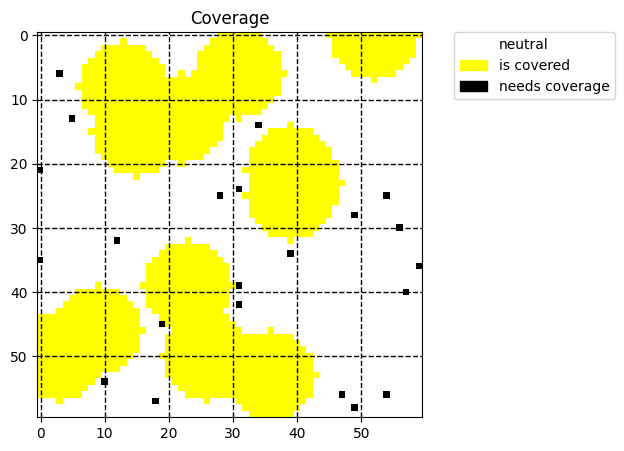

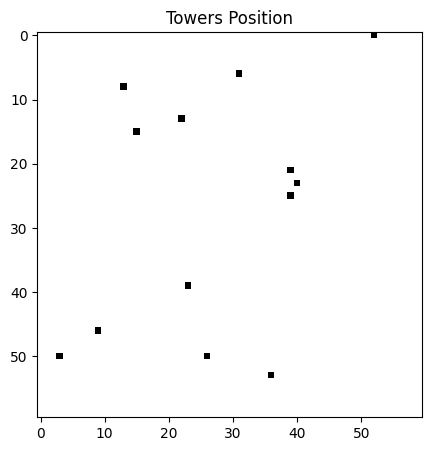

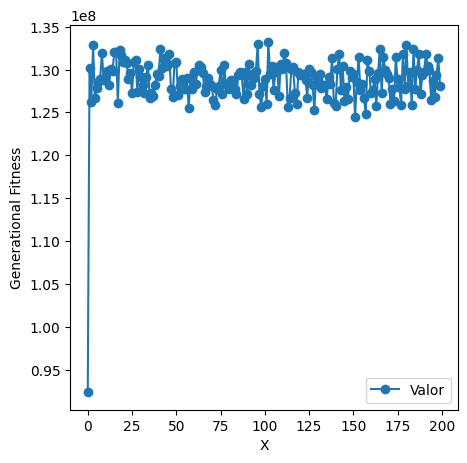

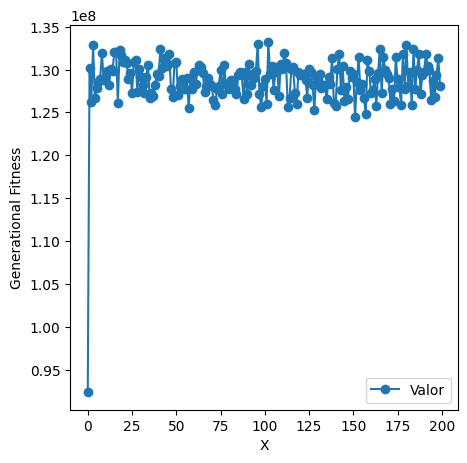

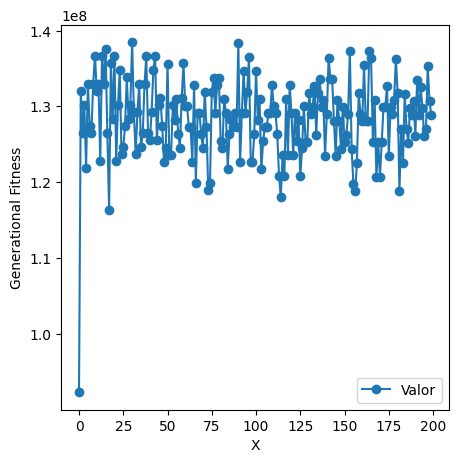

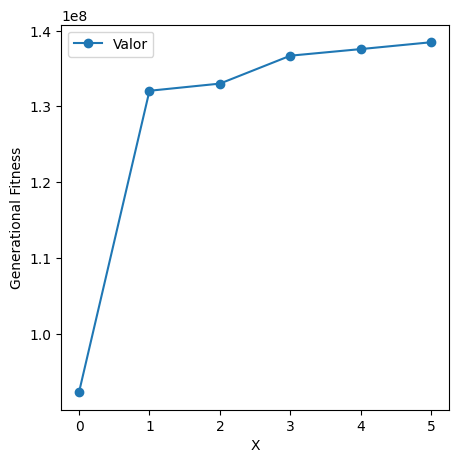

In [67]:
test_landscape = copy.deepcopy(landscape) 
price = 0
# coverage of 7km
test_landscape.add_towers(best_chromosome.get_coordinates(), 7)

towers = best_chromosome.count_towers() 
uncovered = test_landscape.uncovered_count()
coordinates = best_chromosome.get_coordinates()

for y in range(test_landscape.rows()):
    for x in range(test_landscape.cols()):
        if coordinates[y][x] == 1:
            price += test_landscape.matrix[y][x].tower_cost 


print(f'# Cell Towers: {towers}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {uncovered}')
print(f'# Total price: {price}') 

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

draw_graph2(final_array)

draw_graph2(mean_array)

draw_graph2(generational_fitness)
draw_graph2(generational_progress)

3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 

### Answer

For the experimentation we used different sets where the variables were as follows: [tower_probability, population size, max number of generations, mutation rate, crossover rate].

One or more variables of each set are slightly, and in some cases significantly, different from the variables used previously. The list of sets goes as follows:
- variables = [0.01, 200, max_generations, 0.1, 0.6]
- variables = [0.0175, 100, max_generations, 0.2, 0.6]
- variables = [0.025, 100, max_generations, 0.1, 0.6]
- variables = [0.5, 100, max_generations, 1, 0.6]
- variables = [0.005, 100, max_generations, .2, 0.6]

Every single test had a max_generations of 200 generations and were ran five consecutive times for the purpose of getting the fitness average of each generation for a better graphic.

The results obtained were the following:

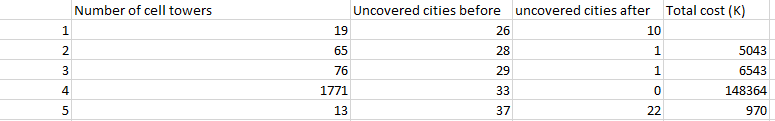

Where each set returned the next graphics:

Set 1: 

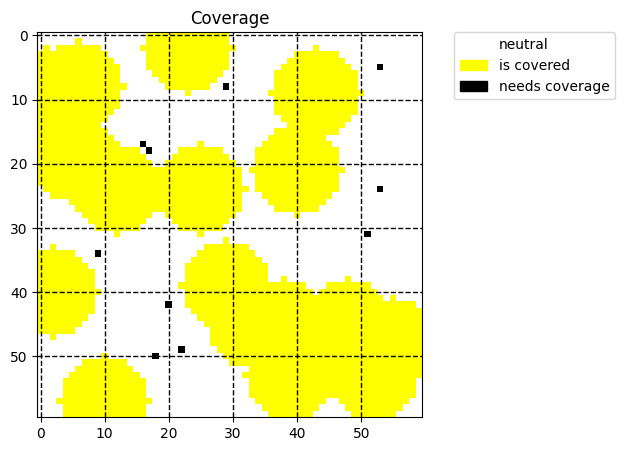 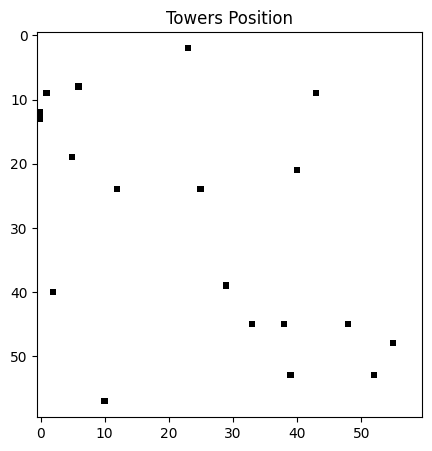 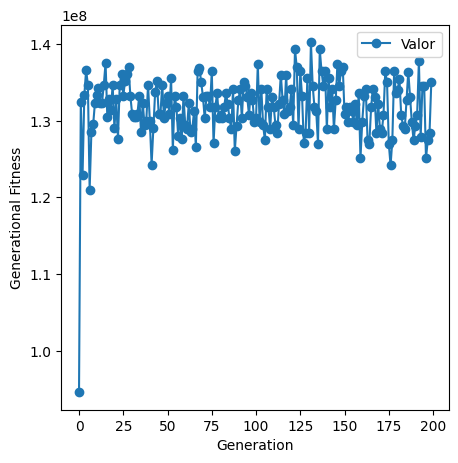 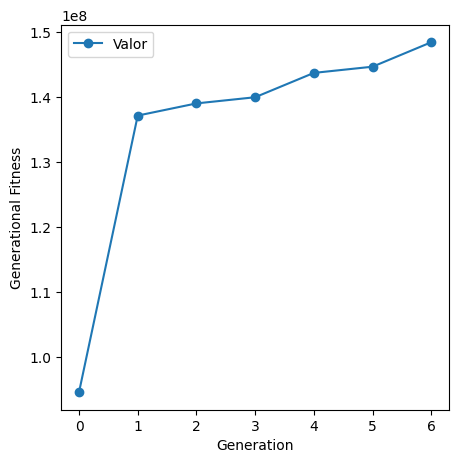

Set 2:

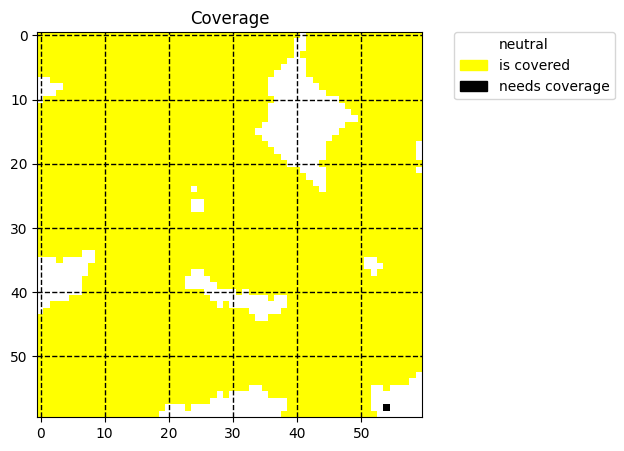 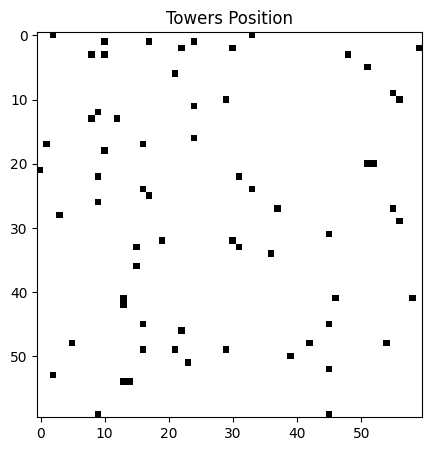 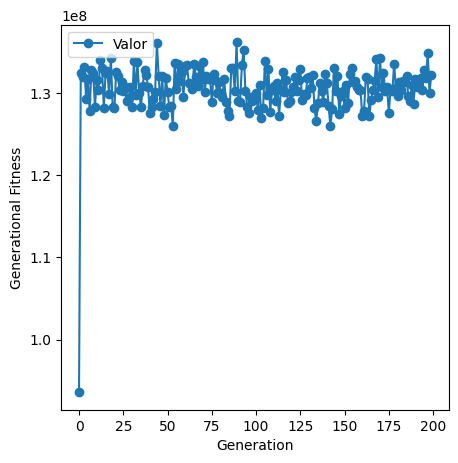 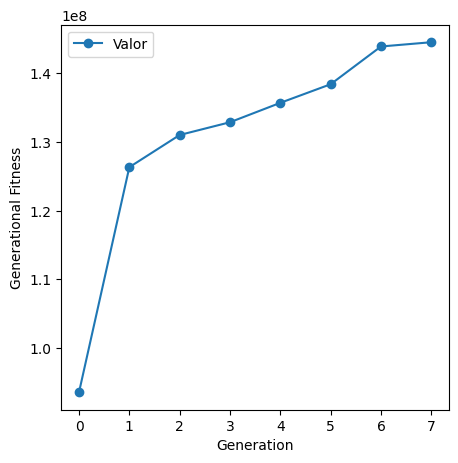

Set 3:

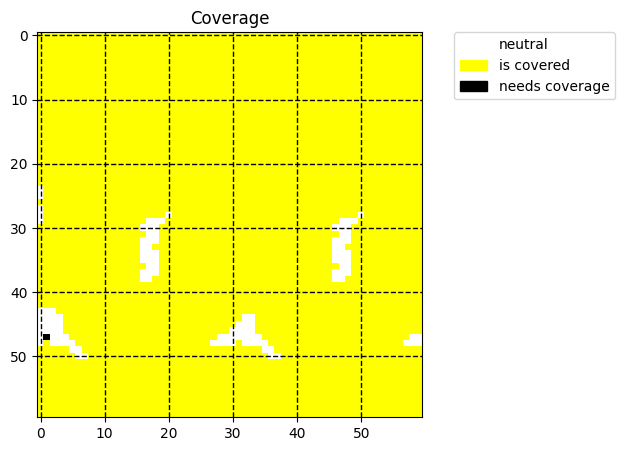 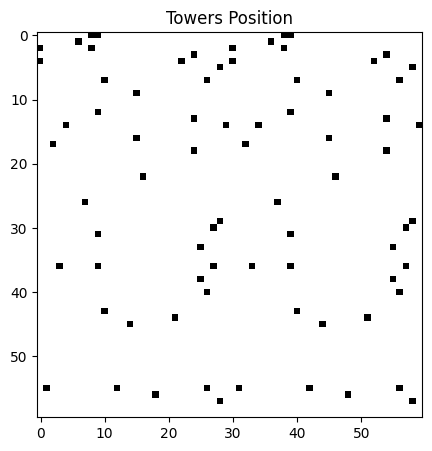 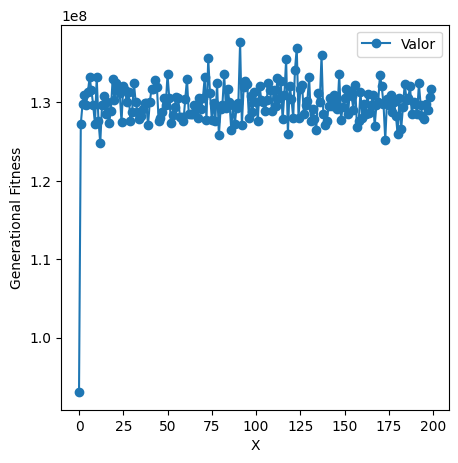 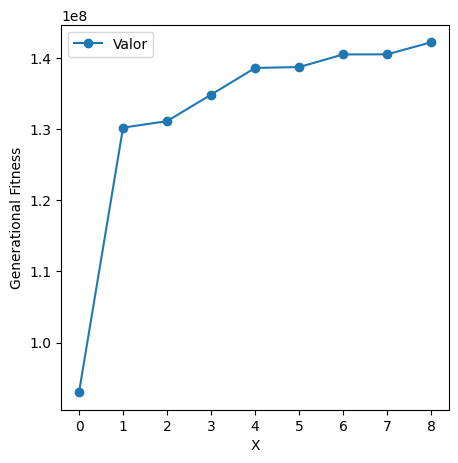

Set 4:

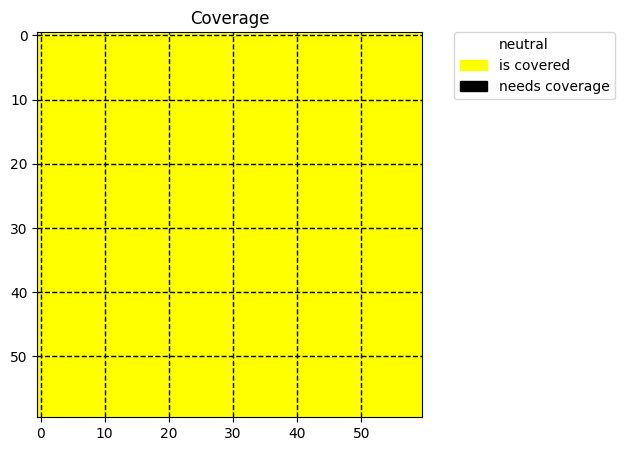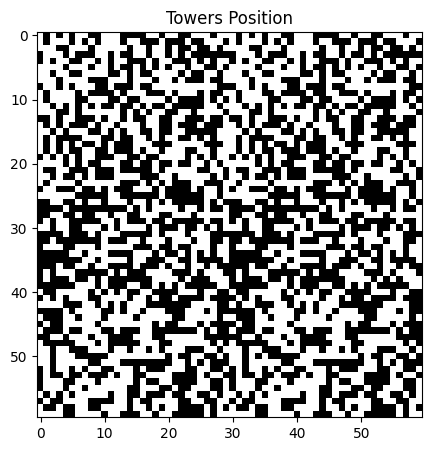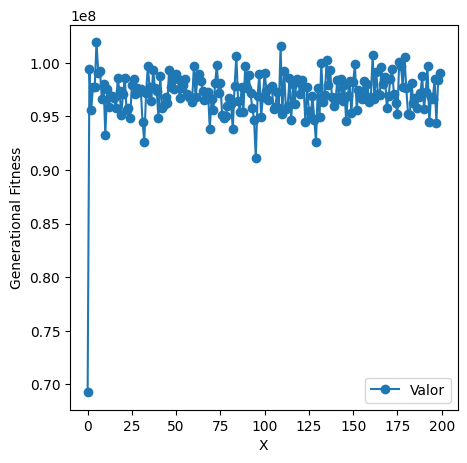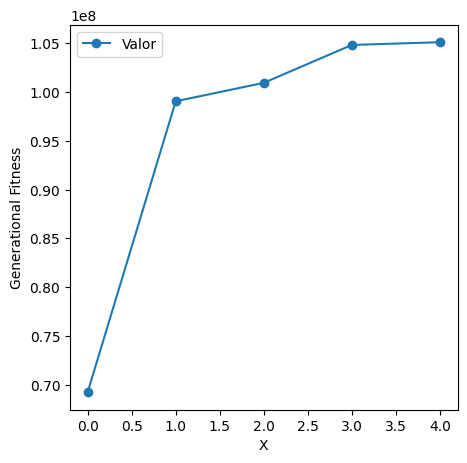
 

Set 5:

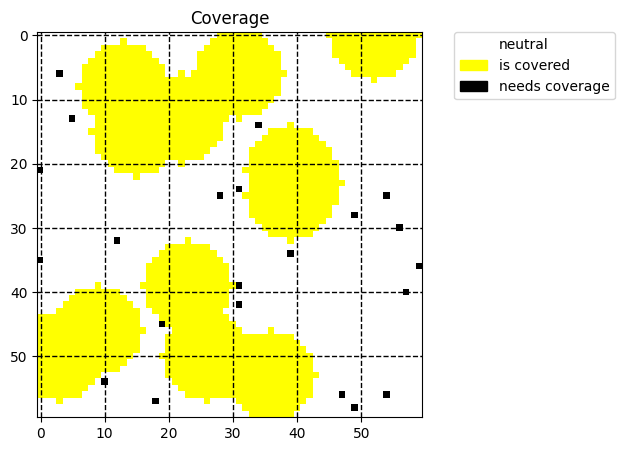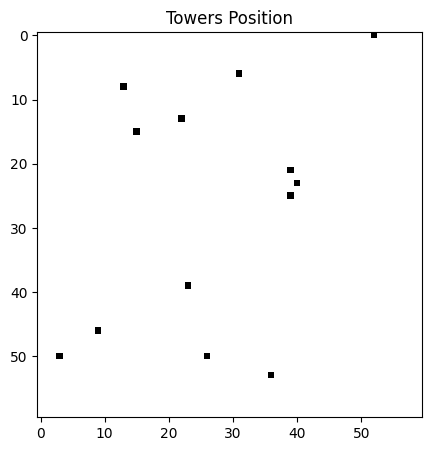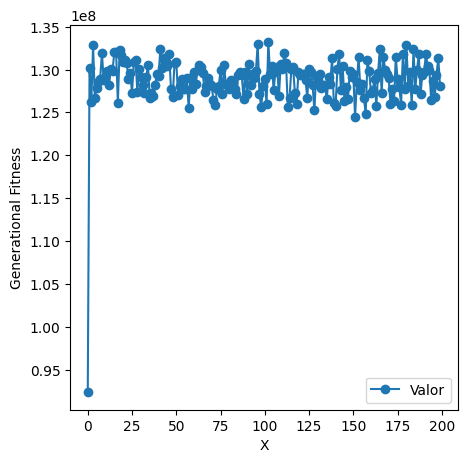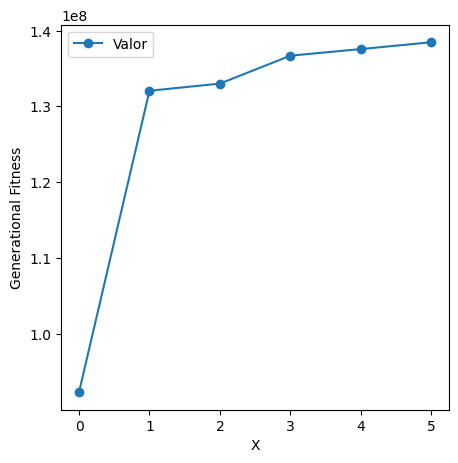



The average fitness function of each set was:
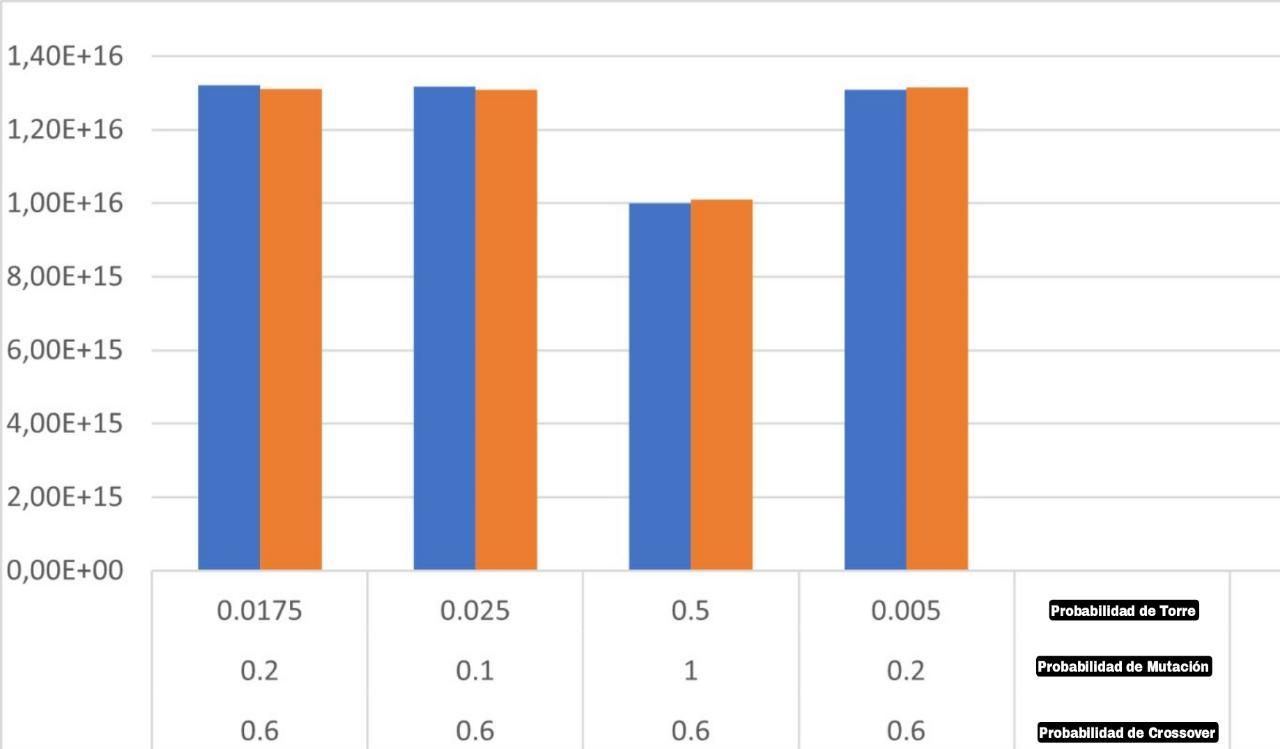

We must be aware that we will not always find the solution, but in this case, we managed to find a solution that allows for a large population to be covered with the least amount of towers and at the best possible price with the type of algorithm we developed, and based on changes in strategies and probabilities in our empirical experiments. 

In the case of our experiments, we were able to notice that if our probability of crossover or mutation is too high, there is a tendency to converge to suboptimal solutions, and if it is too low, the algorithm takes a long time to find an optimal solution. 

For example on the fourth set both the Tower probability and mutation probability were absurdly high, due to the exaggeration of these parameters the amount of towers placed was innecesarly high and its cost was really elevated too.

On the other end, the fifth set had abnormally low probabilities to place a tower on the map, this choice caused most cities to go uncovered, failing the principal task of the algorithm.

In conclusion, having exaggerated values on any parameter will lead too suboptimal solutions, that will take too much time or cost too much, verifying the hypothesis presented above.

### 4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 

The best solution we got was seen on the second set with the variables:

- variables = [tr_prob = 0.0175, pop_size = 100, max_generations = 200, mutation_rate = 0.2, corssover_rate = 0.6]

As seen on the images included on the previous question, this iteration of the algorithm was able to cover almost all cities -expect for one- using 65 cell towers. The total cost of ths installation totaled 5043K or around 5 million dollars.

Compared to our other test, this iteration got the lowest amount of cell towers installed and by proxy spent the lowest amount between the 5 tests.
